# Model Design: Match through Landmark Likelihood

### Required Modules

In [58]:
import os
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Individual Pose Check

In [59]:
training_data_path = 'data/processed/static-pole-fitness/00173.csv'
user_data_path = 'data/processed/testing/00002.csv'

In [60]:
td = pd.read_csv(training_data_path)
xt = td['x'].tolist()
yt = td['y'].tolist()
zt = td['z'].tolist()
td_tuple = [(xt[i], yt[i],zt[i]) for i in range(len(xt))]

ud = pd.read_csv(user_data_path)
xu = ud['x'].tolist()
yu = ud['y'].tolist()
zu = ud['z'].tolist()
ud_tuple = [(xu[i], yu[i],zu[i]) for i in range(len(xu))]

In [79]:
def are_close_to_origin(landmark_set,threshold):
    score = 0
    for element in landmark_set:
        if element <= threshold:
            score += 1
    if score == 3:
        return True
    else:
        return False

def compare_sets(set1, set2, threshold):
    difference_set = []
    least_indices = []
    pose_index = 0
    for point1, point2 in zip(set1, set2):
        landmark_set = [abs(p1 - p2) for p1, p2 in zip(point1, point2)]
        difference_set.append(landmark_set)
        pose_likelihood = are_close_to_origin(landmark_set,threshold)        
        
        if pose_likelihood:
            least_indices.append(pose_index)
        pose_index += 1
    
    if len(least_indices) < 0:
        print("no landmark matches found")
            
    return difference_set,least_indices

threshold = 0.2
difference_set,least_indices = compare_sets(td_tuple, ud_tuple, threshold)

In [80]:
print("closest poses are found in these landmarks:")

for i in least_indices:
    print(i, difference_set[i])

closest poses are found in these landmarks:
23 [0.1121326088905335, 0.19089871644973755, 0.010326292365789497]
24 [0.08853945136070257, 0.17175161838531494, 0.0102623440325261]
26 [0.12148571014404297, 0.09703177213668818, 0.040904588997364]


## Batch Pose Check

In [100]:
def find_best_pose_match(training_data_dir, user_data_path, threshold):
    best_image = ''
    best_solution = []
    matches = 0
    
    try:
        if not os.path.exists(training_data_dir) or not os.path.exists(user_data_path):
            return False

        training_data_files = []

        for filename in os.listdir(training_data_dir):
            if filename.endswith(".csv"):
                training_data_files.append(os.path.join(training_data_dir, filename))

        training_data_files.sort()

        solutions = {}
        
        ud = pd.read_csv(user_data_path)
        xu = ud['x'].tolist()
        yu = ud['y'].tolist()
        zu = ud['z'].tolist()
        ud_tuple = [(xu[i], yu[i],zu[i]) for i in range(len(xu))]

        for i, training_data_file in enumerate(training_data_files):

            td = pd.read_csv(training_data_file)
            xt = td['x'].tolist()
            yt = td['y'].tolist()
            zt = td['z'].tolist()
            td_tuple = [(xt[i], yt[i],zt[i]) for i in range(len(xt))]
            
            difference_set,least_indices = compare_sets(td_tuple, ud_tuple, threshold)
            
            if len(least_indices) > matches:
                matches = len(least_indices)
                best_image = filename
                best_solution = difference_set
                best_solution_landmarks = least_indices
                
        return best_solution, best_image, matches

    except Exception as e:
        print(f"An error occurred: {str(e)}")
    return False

In [101]:
training_data_dir = 'data/processed/static-pole-fitness'
user_data_path = 'data/processed/testing/00002.csv'
best_solution, best_image, matches = find_best_pose_match(training_data_dir, user_data_path, 0.1)

In [102]:
print(best_image, matches)

00295.csv 14


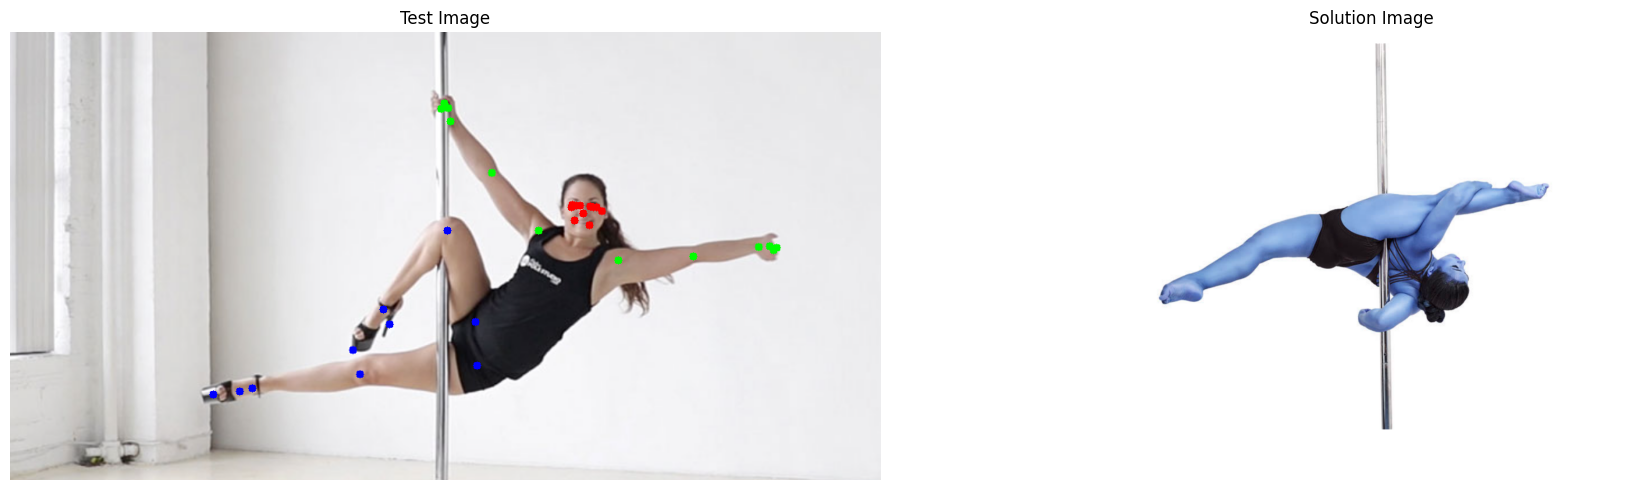

In [103]:
user_image = 'data/processed/testing/00002.png'
solution_image = 'data/external/static-pole-fitness/00295.png'

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].imshow(cv2.imread(user_image))
axs[0].set_title("Test Image")
axs[0].axis(False)
axs[1].imshow(cv2.imread(solution_image))
axs[1].set_title("Solution Image")
axs[1].axis(False)


fig.tight_layout()
plt.show()